<a href="https://colab.research.google.com/github/mikeyshean/pytorch-notebooks/blob/master/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn # contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch verision
torch.__version__

'1.12.1+cu113'

## Data (preparing and loading)

Data can be almost anything in ML

* Excel spreadsheet
* Images of any kind
* Videos
* Audio
* DNA
* Text

ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation


Use a linear regression formula to make a straigh tline with *known* **parameters**

In [ ]:
# Create known parameters  
# Y = a + bX
weight = 0.7 # b
bias = 0.3   # a

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]), 50, 50)

In [ ]:
X.shape

torch.Size([50, 1])

### Splitting data into training and validation/test sets (one of the most important concepts in ML in general)

- Training set:  Model learns patterns
- Validation set:  Tune the model on data not seen in training set
- Test set:  See if the model is ready with data not seen in training/validation sets

In [ ]:
#  Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualize Data

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data, and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

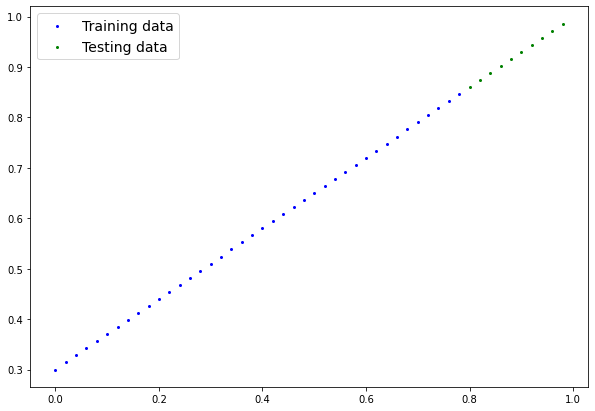

In [ ]:
plot_predictions()

## 2. Build model

Our first PyTorch model!

Resource for Python OOP: https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent the ideal values

How does it do it?

Through two main algorithms: (https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
1. Gradient descent
2. Backpropagation


In [ ]:
from torch import nn

# Create a linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,  # <- start with random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- Can this be updated with gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float/float32
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### PyTorch model building esssentials

* `torch.nn` - Contains all of the building blocks for computational graphs (a nn can be considered a computational graph)
* `torch.nn.Parameter` - What parameters should our model try to learn, often a PyTorch layer from `torch.nn` will set these for us
* `torch.nn.Module` - The base class for all neural network modules, if you sublcass it, you should override `forward()`
* `torch.optim` - This is where the optimizers in PyTorch live, they will help with gradient descent
* `forward()` - All `nn.Module` subclasses require you to override `forward()`, this method defines what happens in the forward computation 

### Check the contents of our PyTorch model
* `.parameters()`:  Check our model parameters

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameterse
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method

More on `inference_mode()`: https://twitter.com/pytorch/status/1437838231505096708

In [ ]:
# Make predictions with model
with torch.inference_mode(): # disables grad tracking, can improve performance 
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

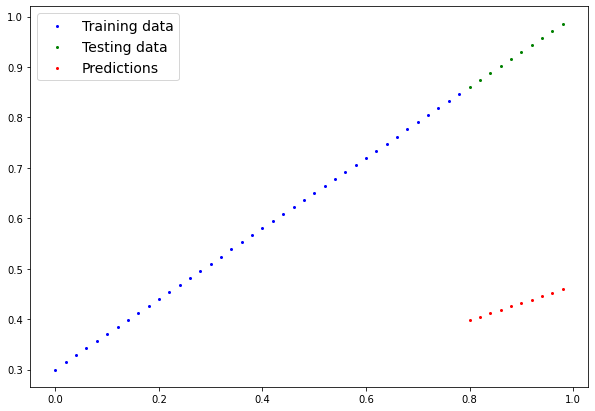

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

Move from *unknown* parameters (could be random) to *known* params

One way to measure how poor the predictions are is with **loss functions**

* Note:  Loss function may also be referred to as a cost function or criterion

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs.  Lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function
 * Inside the optimizer you'll often have to set two parameters:
   * `param` - the moel parameters you'd like to optimize, for example `params=model_0.parameters()`
   * `lr` (learning rate) - the learning rate is a *hyperparameter* that defines how big/small the optimizer changes the parameterse with each step (small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# Check out the model's parameters (value the model adjusts)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss() # L1Loss == MAE == Mean Absolute Error

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # learning rate:  Possibly the most impactful hyperparameter you can set

### Building a training loop (and a testing loop) in PyTorch

A couple things we need in a training loop:
0. Loop through the data and for each:
1. Forward pass (this involves data moving through our model's `forward()` function(s)) to make predictions on data - also called forward propagation 
2. Calculate the loss (compare forward pass predicitons to ground truth labels)
3. Optimizer zero grad
4. Loss backwards - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try to improve the loss (**gradient descent**)

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# An epoch is one loop through the data (another hyperparameter because we've set it ourselves)
epochs = 200

# Track different values (help with tracking this model against future experiments)
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. Calcualte the loss
  loss = loss_fn(y_pred, y_train )
  # print(f'Loss: {loss}')

  # 3. Optimizer zero grad (resets step calculated in #5 for next loop)
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the params of the mode
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()  # by default, the optimizer changes with accumulate throughout the loop, need to `zero_grad` explicitly to reset

  ### Testing
  model_0.eval() # turns off gradient tracking among other settings in the model not needed for evaluation/testing (dropout / batch norm layers)

  with torch.inference_mode(): # turns off gradient tracking & others not needed for testing
  # with torch.no_grad(): # you may also see this inolder PyTorch code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

    # Print out model state_dict()
    print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

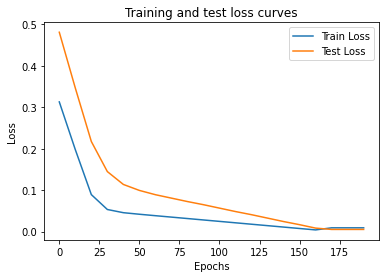

In [ ]:
import numpy as np

# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
with torch.inference_mode(): # turns off gradient tracking & others not needed for testing
  y_preds_new = model_0(X_test)


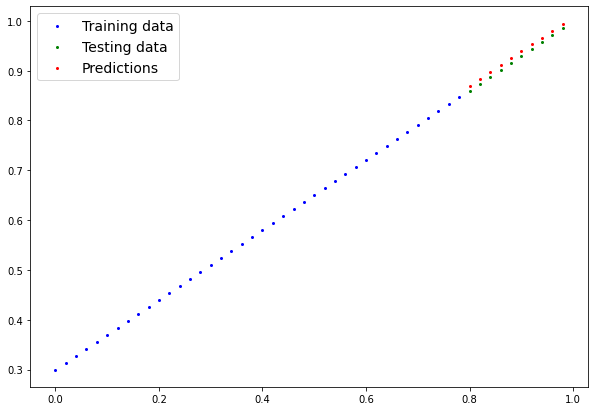

In [ ]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in Pytorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary

Ref: https://pytorch.org/tutorials/beginner/saving_loading_models.html


In [ ]:
# Save our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_worflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_worflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1063 Nov 12 19:48 01_pytorch_worflow_model_0.pth


## Loading a PyTorch model

Since we saved our models `state_dict()` rather than the entire model, we'll create a new instance of our model and load the saved `state_dict()` into that

In [ ]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Make some model preds
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Go through the steps above and see it all in one place

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.12.1+cu113'

Create device-agnostic code

ref: https://pytorch.org/blog/pytorch-0_4_0-migration-guide/#writing-device-agnostic-code

In [ ]:
# Setup device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
!nvidia-smi

Sat Nov 12 19:48:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 6.1 Data

In [ ]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create a range of values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

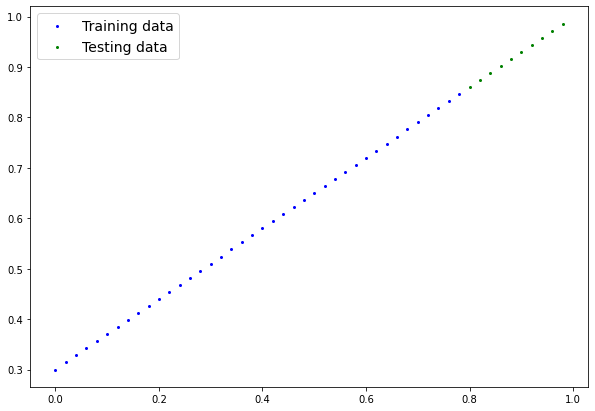

In [ ]:
# Plot the data
# Note: if you dont have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Build a PyTorch Linear Model

In [ ]:
# model definition
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use the target device
model_1.to(device)

# Check again
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we needs:
- Loss function
- Optimizer
- Training loop
- Testing loop

In [ ]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)


In [ ]:
# Write a training loop
torch.manual_seed(42)

# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 200
for epoch in range(epochs):
  model_1.train()

  # 1. Do the forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero_grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():

    # 6. Do the forward pass
    y_test_preds = model_1(X_test)

    # 7. Calculate the loss
    test_loss = loss_fn(y_test_preds, y_test)
  
  # Print out whats happening
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}')



Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
weight, bias

(0.7, 0.3)

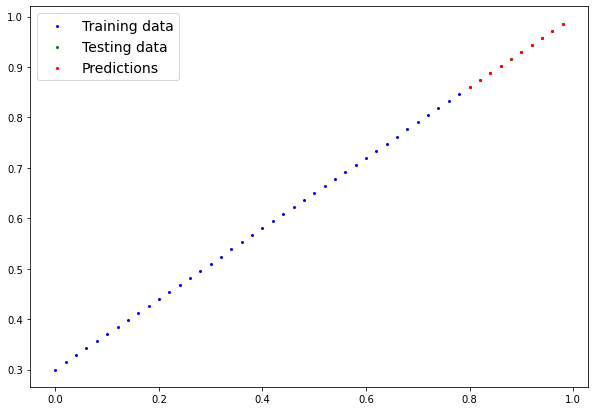

In [ ]:
plot_predictions(train_data=X_train.cpu(),
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu(),
                 predictions=y_test_preds.cpu())

### 6.4 Making and evaluating predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test) 

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

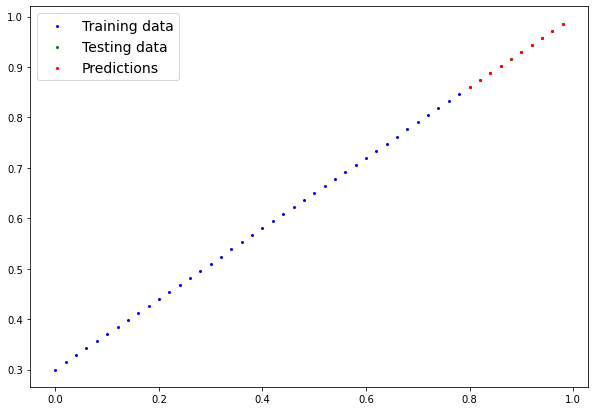

In [ ]:
#  Check out our model predictions visually
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving & loading a trained model


In [ ]:
# Save the model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create file save path
MODEL_NAME = "01_model_save_again.pth"
FILE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f'Saving model to: {FILE_PATH}')
torch.save(model_1.state_dict(), FILE_PATH)

In [ ]:
# Load the saved model
loaded_model = LinearRegressionModelV2()
loaded_model.load_state_dict(torch.load(FILE_PATH))

loaded_model.state_dict()


OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [ ]:
# Run predictions

loaded_model.to(device)
loaded_model.eval()
with torch.inference_mode():
  y_preds_loaded = loaded_model(X_test)

y_preds_loaded

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

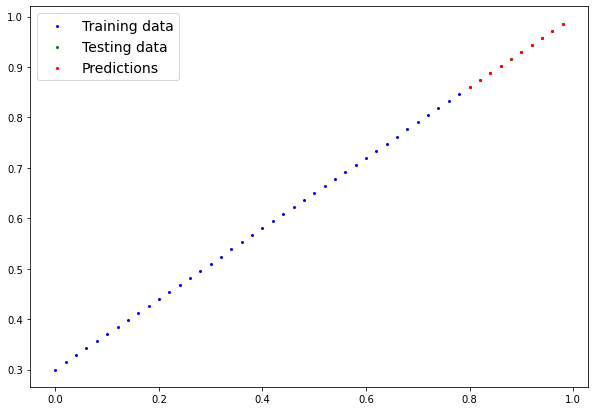

In [ ]:
plot_predictions(predictions=y_preds_loaded.cpu())